In [1]:
import os
import shutil
from tqdm import tqdm

# Paths
utkface_folder = "D:/juli/archive (4)/UTKFace" # your dataset path
output_folder = "UTKFace_NationalitySplit"

# Create nationality mapping from race
def get_nationality_from_race(race):
    if race == 3:  # Asian and Indian
        return "Indian"
    elif race == 0:
        return "American"
    elif race == 1:
        return "African"
    elif race == 2:
        return "Asian"
    else:
        return "Other"

# Prepare output folders
nationalities = ["American", "African", "Asian", "Indian", "Other"]
for nationality in nationalities:
    os.makedirs(os.path.join(output_folder, nationality), exist_ok=True)

# Process each image
for filename in tqdm(os.listdir(utkface_folder)):
    if filename.endswith(".jpg"):
        try:
            parts = filename.split("_")
            age = int(parts[0])
            gender = int(parts[1])
            race = int(parts[2])
            nationality = get_nationality_from_race(race)

            src = os.path.join(utkface_folder, filename)
            dst = os.path.join(output_folder, nationality, filename)
            shutil.copy(src, dst)
        except Exception as e:
            print(f"Skipping {filename}: {e}")


 63%|████████████████████████████████████████████████▏                           | 15022/23708 [03:45<01:52, 77.29it/s]

Skipping 39_1_20170116174525125.jpg.chip.jpg: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


 88%|██████████████████████████████████████████████████████████████████▋         | 20804/23708 [05:24<00:39, 72.95it/s]

Skipping 61_1_20170109142408075.jpg.chip.jpg: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping 61_1_20170109150557335.jpg.chip.jpg: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'


100%|████████████████████████████████████████████████████████████████████████████| 23708/23708 [06:07<00:00, 64.48it/s]


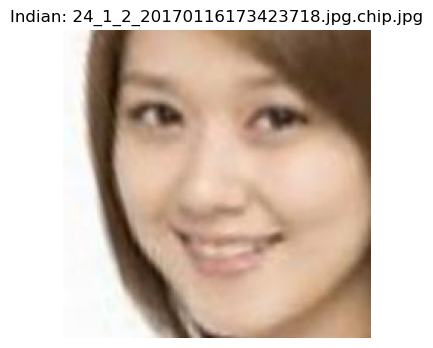

In [2]:
import matplotlib.pyplot as plt
import cv2
import random

# Change this path if needed
base_folder = "UTKFace_NationalitySplit"

# Pick a nationality to visualize
nationality = "Indian"  # try "American", "African", etc.
folder = os.path.join(base_folder, nationality)

# Random image sample
sample_file = random.choice(os.listdir(folder))
img_path = os.path.join(folder, sample_file)

# Display
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.title(f"{nationality}: {sample_file}")
plt.axis('off')
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


img_size = 128  # better resolution for pretrained models
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    'UTKFace_NationalitySplit',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    'UTKFace_NationalitySplit',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 21714 images belonging to 5 classes.
Found 5425 images belonging to 5 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),   # extra conv layer
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(5, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\juli\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,693 (12.61 MB)

 Trainable params: 3,305,989 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
from tensorflow.keras.models import load_model
model=load_model("nationality_model.h5")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_nationality_model.h5", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


C:\Users\juli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7032 - loss: 0.7185

679/679 ━━━━━━━━━━━━━━━━━━━━ 1056s 2s/step - accuracy: 0.7032 - loss: 0.7185 - val_accuracy: 0.6630 - val_loss: 0.8274
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7088 - loss: 0.7075

679/679 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - accuracy: 0.7088 - loss: 0.7075 - val_accuracy: 0.6675 - val_loss: 0.8154
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.7072 - loss: 0.6898 - val_accuracy: 0.6142 - val_loss: 1.2369
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 896s 1s/step - accuracy: 0.7178 - loss: 0.6788 - val_accuracy: 0.6455 - val_loss: 0.8943
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 861s 1s/step - accuracy: 0.7123 - loss: 0.6858 - val_accuracy: 0.6343 - val_loss: 0.8930
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 841s 1s/step - accuracy: 0.7161 - loss: 0.6697 - val_accuracy: 0.6535 - val_loss: 0.8293
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 844s 1s/step - accuracy: 0.7114 - loss: 0.6735 - val_accuracy: 0.6641 - val_loss: 0.8222


In [7]:
model.save("nationality_model.h5")


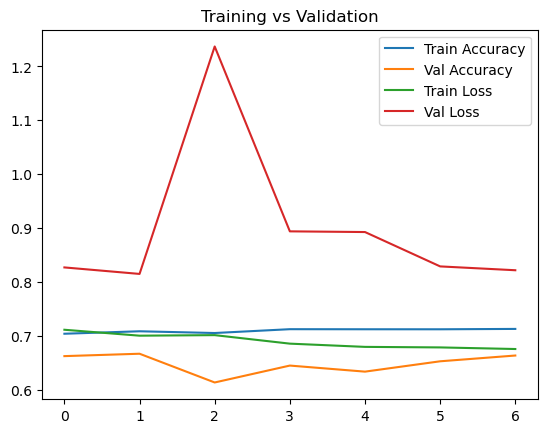

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation")
plt.show()



In [9]:
print(train_gen.class_indices)

print("Train classes:", train_gen.class_indices)
print("Validation classes:", val_gen.class_indices)
print("Number of classes:", train_gen.num_classes)

print(len(train_gen.class_indices))
print(len(val_gen.class_indices))


{'African': 0, 'American': 1, 'Asian': 2, 'Indian': 3, 'Other': 4}
Train classes: {'African': 0, 'American': 1, 'Asian': 2, 'Indian': 3, 'Other': 4}
Validation classes: {'African': 0, 'American': 1, 'Asian': 2, 'Indian': 3, 'Other': 4}
Number of classes: 5
5
5


In [10]:
x_batch, y_batch = next(train_gen)
print("Batch x shape:", x_batch.shape)
print("Batch y shape:", y_batch.shape)
print("Sample labels (one-hot):", y_batch[0])
print("Sum of one-hot labels:", y_batch[0].sum())  # should be 1.0


Batch x shape: (32, 128, 128, 3)
Batch y shape: (32, 5)
Sample labels (one-hot): [0. 1. 0. 0. 0.]
Sum of one-hot labels: 1.0
